# Perspective Transforms

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import galflow as gf
from tensorflow_addons import image as tfa_image

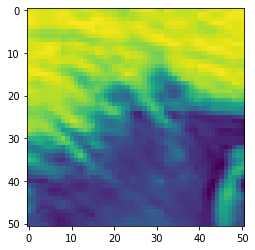

In [3]:
from scipy.misc import face
image = face(gray=True)[-512:-512+128,-512:-512+128].astype('float32')[0:51,0:51]
image_tf = tf.convert_to_tensor(image.reshape([1,51,51, 1]))
imshow(image_tf[0,...,0])

In [4]:

g1 = tf.convert_to_tensor([0.0], dtype=tf.float32)
g2 = tf.convert_to_tensor([0.5], dtype=tf.float32)
gsqr = g1**2 + g2**2

# Building a batched jacobian
jac = tf.stack([ 1. + g1, g2,
              g2, 1. - g1], axis=1) / tf.expand_dims(tf.sqrt(1.- gsqr),1)
jac = tf.reshape(jac, [-1,2,2])

# Inverting these jacobians to follow the TF definition

jac = tf.linalg.inv(jac)
jac = tf.pad(jac, tf.constant([[0, 0], [0, 1],[0,1]]) )
jac = jac + tf.pad(tf.reshape(tf.ones_like(g1), [-1,1,1]), tf.constant([[0,0],[2,0],[2,0]]))
jac

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[ 1.1547005 , -0.57735026,  0.        ],
        [-0.57735026,  1.1547005 ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]], dtype=float32)>

In [5]:
#If fourier
g1 = tf.convert_to_tensor([0.0], dtype=tf.float32)
g2 = tf.convert_to_tensor([0.5], dtype=tf.float32)
gsqr = g1**2 + g2**2

# Building a batched jacobian
jac = tf.stack([ 1. + g1, g2,
              g2, 1. - g1], axis=1) / tf.expand_dims(tf.sqrt(1.- gsqr),1)
jac = tf.reshape(jac, [-1,2,2])

# Inverting these jacobians to follow the TF definition

jac =  tf.transpose(jac, [0,2,1])

jac = tf.pad(jac, tf.constant([[0, 0], [0, 1],[0,1]]) )
jac = jac + tf.pad(tf.reshape(tf.ones_like(g1), [-1,1,1]), tf.constant([[0,0],[2,0],[2,0]]))
jac

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1.1547005 , 0.57735026, 0.        ],
        [0.57735026, 1.1547005 , 0.        ],
        [0.        , 0.        , 1.        ]]], dtype=float32)>

In [6]:
dtype = tf.float32
zero = tf.cast(0.0, dtype)
height, width = 51, 51

In [7]:
def newshear(img,g1,g2,interpolator='bernsteinquintic'):
  
  _ , nx, ny, _ = img.get_shape().as_list()
  g1 = tf.convert_to_tensor(g1, dtype=tf.float32)
  g2 = tf.convert_to_tensor(g2, dtype=tf.float32)
  gsqr = g1**2 + g2**2

  ddt = (1. + g1)*( 1. - g1) - g2**2
  
  # Building a batched jacobian
  jac = tf.stack([ 1. + g1, g2,
                g2, 1. - g1], axis=1) / tf.expand_dims(tf.sqrt(1.- gsqr),1)
  jac = tf.reshape(jac, [-1,2,2]) 

  # Inverting these jacobians to follow the TF definition
  
  if  img.dtype ==  tf.complex64:
    transform_matrix = tf.transpose(jac,[0,2,1])
  else:
    transform_matrix = tf.linalg.inv(jac)
  
  #define a grid at pixel positions
  warp = tf.stack(tf.meshgrid(tf.linspace(0.,tf.cast(nx,tf.float32)-1.,nx), 
                              tf.linspace(0.,tf.cast(ny,tf.float32)-1.,ny)),axis=-1)[..., tf.newaxis]

  #get center
  center = tf.convert_to_tensor([[height/2],[width/2]],dtype=tf.float32)
  
  #displace center to origin
  warp = warp - center
  
  #if fourier, no half pixel shift needed
  if  img.dtype is not tf.complex64:
    warp +=.5

  #apply shear
  warp = tf.matmul(transform_matrix[:, tf.newaxis, tf.newaxis, ...], warp)[...,0]

  #return center
  warp = warp + center[...,0] 
 
  #if fourier, no half pixel shift needed
  if  img.dtype is not tf.complex64:
    warp -=.5
    
    
  #apply resampler
  if img.dtype == tf.complex64:
    a = tfa_image.resampler(tf.math.real(img),warp,'bernsteinquintic')
    b = tfa_image.resampler(tf.math.imag(img),warp,'bernsteinquintic')
    sheared = tf.complex(a,b)
  else:
    sheared = tfa_image.resampler(img,warp,'bernsteinquintic')
  return sheared, warp

In [21]:
g1 = tf.repeat([0.],2)
g2 = tf.repeat([0.],2)
imgs = tf.repeat(image_tf,2,axis=0)
#mysheared, warp = newshear(image_tf,g1,g2)
gfsheared =gf.shear(imgs,g1,g2)#alter galflow transformation to return warps

In [14]:
tf.repeat(image_tf,2,axis=0)

<tf.Tensor: shape=(2, 51, 51, 1), dtype=float32, numpy=
array([[[[239.],
         [238.],
         [235.],
         ...,
         [241.],
         [242.],
         [242.]],

        [[242.],
         [240.],
         [237.],
         ...,
         [243.],
         [243.],
         [244.]],

        [[244.],
         [242.],
         [239.],
         ...,
         [242.],
         [242.],
         [243.]],

        ...,

        [[ 77.],
         [ 73.],
         [ 66.],
         ...,
         [106.],
         [ 82.],
         [ 68.]],

        [[ 72.],
         [ 70.],
         [ 66.],
         ...,
         [107.],
         [ 84.],
         [ 72.]],

        [[ 70.],
         [ 71.],
         [ 73.],
         ...,
         [ 90.],
         [ 73.],
         [ 66.]]],


       [[[239.],
         [238.],
         [235.],
         ...,
         [241.],
         [242.],
         [242.]],

        [[242.],
         [240.],
         [237.],
         ...,
         [243.],
         [243.],
   

NameError: name 'warps' is not defined

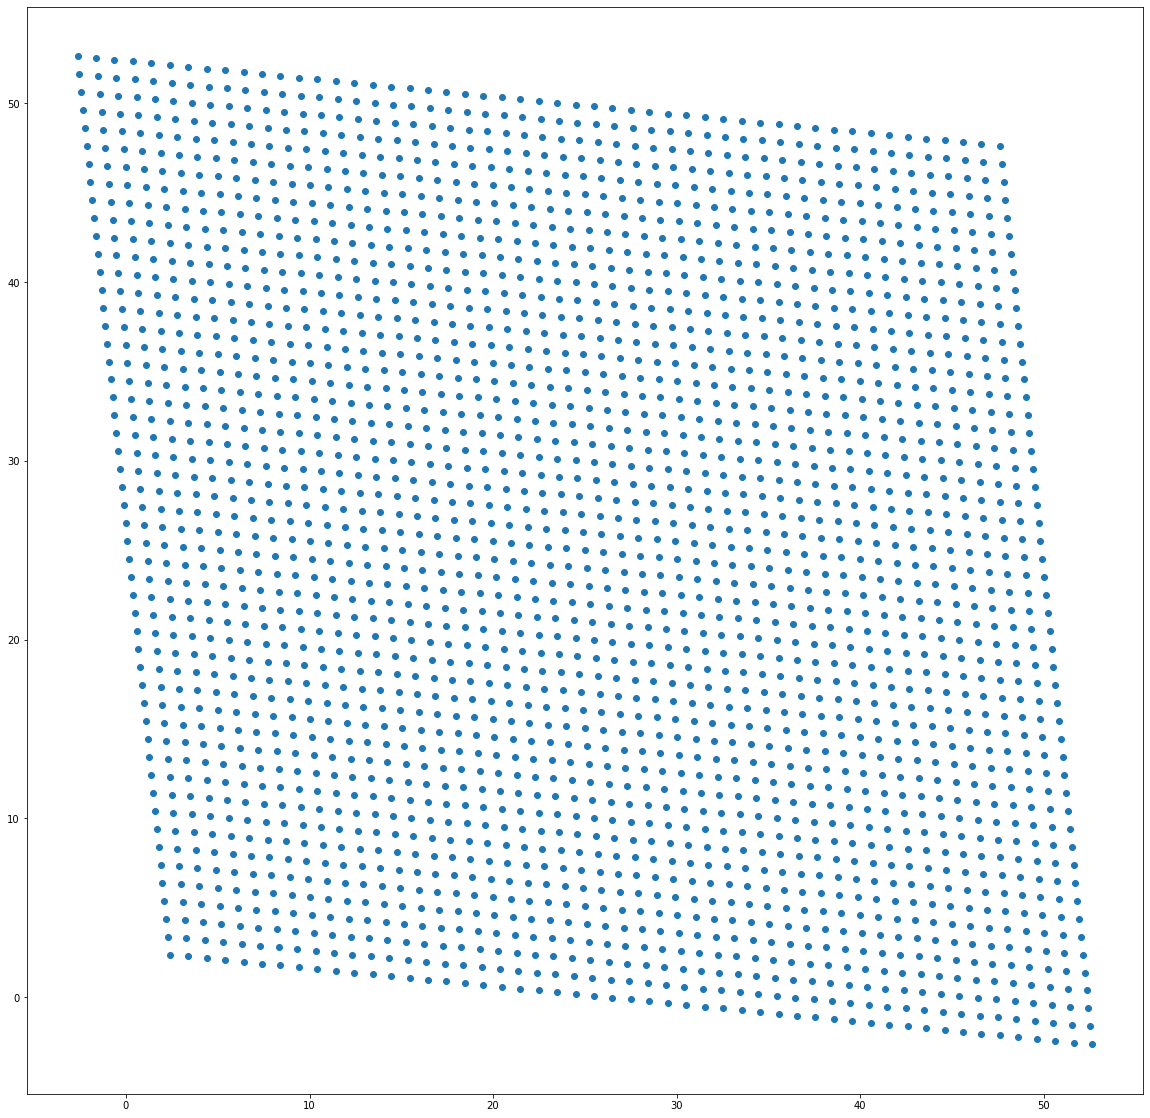

In [9]:
figure(figsize=(20,20))
scatter(warp[...,0],warp[...,1],label="mine")
#scatter(warps[...,0],warps[...,1],label="correct")

legend()
xlim([-10,60])
ylim([-10,60])

plot([0,50],[0,50],'k-')
plot([0,50],[50,50],'k-')
plot([0,50],[0,0],'k-')
plot([50,50],[0,50],'k-')
plot([0,0],[0,50],'k-')
plot([0,50],[50,0],'k-')

In [ ]:
figure(figsize=(27,5))

subplot(141)
imshow(image_tf[0,...,0])
subplot(142)
title('in development')
imshow(mysheared[0,...,0])
subplot(143)
title('correct')
imshow(gfsheared[0,...,0])
subplot(144)
title('diff')
imshow(gfsheared[0,...,0]-mysheared[0,...,0]); colorbar()

In [ ]:
%%timeit
mysheared, warp = newshear(image_tf,g1,g2)

In [ ]:
%%timeit
gfsheared, warps =gf.shear(image_tf,g1,g2)